# Preparation of the analysis
## Importing the libraries

In [15]:
import pandas as pd
import os
import tarfile
import gzip
import datetime
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


## Importing the dataset

We first define the path to the dataset.

In [16]:
PATH_BA = '../Data/BeerAdvocate_CSV.tar.gz'
PATH_RB = '../Data/RateBeer_CSV.tar.gz'
folder_BA = tarfile.open(PATH_BA)
folder_RB = tarfile.open(PATH_RB)

We now import the dataset and convert the different .csv files to pandas dataframes. This is done on both BeerAdvocate and RateBeer datasets. For each dataset we obtain four dataframes: one for the reviews, one for the beers, one for the breweries and one for the users.

In [17]:
# Extracting the files for BeerAdvocate
df_beers_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/beers.csv')))
df_users_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/users.csv')))
df_reviews_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/reviews.csv')))
df_breweries_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/breweries.csv')))

# Extracting the files for RateBeer
df_beers_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/beers.csv')))
df_users_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/users.csv')))
df_reviews_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/reviews.csv')))
df_breweries_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/breweries.csv')))

## Preprocessing the dataframes

### Adding location information to the dataframes

For the review dataframes of both datasets, we want to add two columns that corresponds to the country of the user and the country of the brewery. We do this by extracting the information from the user and brewery dataframes and merging them with the review dataframe. In the end, we obtain `df_RB` and `df_BA` which have the reviews of RateBeer and BeerAdvocate respectively.

In [18]:
#RateBeer
user_nat_RB=pd.DataFrame()
user_nat_RB['user_name']=df_users_RB['user_name']
user_nat_RB['location_user']=df_users_RB['location']
new_reviews_RB=pd.merge(df_reviews_RB, user_nat_RB,  how='inner', on='user_name')

beers_nat_RB=pd.DataFrame()
beers_nat_RB['beer_id']=df_breweries_RB['id']
beers_nat_RB['beers_location']=df_breweries_RB['location']
new_reviews_RB['beer_id']=new_reviews_RB['beer_id'].apply(lambda x: int(x))
df_RB= pd.merge(new_reviews_RB, beers_nat_RB, how='inner', on='beer_id')

#BeerAdvocate
user_nat_BA=pd.DataFrame()
user_nat_BA['user_name']=df_users_BA['user_name']
user_nat_BA['location_user']=df_users_BA['location']
new_reviews_BA=pd.merge(df_reviews_BA, user_nat_BA,  how='inner', on='user_name')

beers_nat_BA=pd.DataFrame()
beers_nat_BA['beer_id']=df_breweries_BA['id']
beers_nat_BA['beers_location']=df_breweries_BA['location']
new_reviews_BA['beer_id']=new_reviews_BA['beer_id'].apply(lambda x: int(x))
df_BA = pd.merge(new_reviews_BA, beers_nat_BA, how='inner', on='beer_id')

In [19]:
df_BA

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location_user,beers_location
0,London Porter,35868,Paddock Wood Brewing Co.,8203,English Porter,5.3,1415962800,nmann08,nmann08.184925,3.75,3.50,3.5,3.75,3.5,3.62,"From a bottle, pours a cola brown color with a...","United States, Washington","United States, Nebraska"
1,London Porter,35868,Paddock Wood Brewing Co.,8203,English Porter,5.3,1195124400,IronDjinn,irondjinn.2090,4.00,4.00,3.0,3.50,3.5,3.60,Picked this up originally in Paddock Wood's &q...,Canada,"United States, Nebraska"
2,London Porter,35868,Paddock Wood Brewing Co.,8203,English Porter,5.3,1368266400,LampertLand,lampertland.635201,4.00,3.75,4.0,4.00,4.0,3.94,"Paddock Wood Brewing 'London Porter' @ 5.2% , ...",Canada,"United States, Nebraska"
3,London Porter,35868,Paddock Wood Brewing Co.,8203,English Porter,5.3,1290596400,biboergosum,biboergosum.168458,3.00,3.50,4.0,4.00,3.5,3.72,"This beer pours a very dark brown colour, with...",Canada,"United States, Nebraska"
4,London Porter,35868,Paddock Wood Brewing Co.,8203,English Porter,5.3,1305453600,andrenaline,andrenaline.393082,3.50,3.50,4.0,4.00,4.0,3.85,"A - Pours a dark ruby red colour, finger of mo...",Canada,"United States, Nebraska"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752759,"""M""-perial Stout",48694,"Mash House Restaurant & Brewery, The",1502,Russian Imperial Stout,7.5,1268478000,kcustom11,kcustom11.264828,3.00,3.50,3.0,4.00,3.0,3.52,A- dark brown like watered down coffeeS- sweet...,"United States, North Carolina",Italy
752760,Fistful-O-Hop India Pale Ale,47760,Lawson's Finest Liquids,17980,American IPA,6.1,1333101600,Bluesquirrel,bluesquirrel.670390,4.50,5.00,4.0,4.50,4.5,4.57,My brother and I got the last 2 bottles at War...,"United States, Vermont",Canada
752761,"Joe's ""How I Got Fired"" High Octane Ale",31492,Mohegan Cafe and Brewery,1163,Scotch Ale / Wee Heavy,8.0,1432461600,adjunct,adjunct.990263,2.00,2.00,1.5,1.00,1.5,1.45,"It looked like beer, and it kind of tasted lik...",NaN,"United States, Connecticut"
752762,Schwindel Alt,47170,Vertigo Brewing,18816,Altbier,5.1,1267786800,jlosel,jlosel.209653,4.50,4.50,4.5,5.00,5.0,4.80,"This a wonderfully delicious brew, especially ...","United States, Oregon","United States, Washington"


#### Adding states for the US based locations

The geographical information contain the name of the country for users and breweries. However, for the US based locations, we also have the name of the state. We want to extract this information and add it to the dataframe. To do so we create will create an extra column for both breweries and users that will contain the US postal abbreviations for each state.

We first extract the postal abbreviations for each state from wikipedia using `pd.read_html`. 

We then process the dataframe into one (`US_states`) containing a column for the postal abbreviations and another one for the corresponding state names. We create from `US_states` two dataframes: `US_states_user` and `US_states_beer`. 

We add the corresponding postal abbreviation to the user and brewery dataframes. We do this by merging the `df_BA` and `df_RB` dataframes with `US_states_user` and `US_states_beer` respectively. 

We then finish processing the locations by dropping the state name in the location column.


In [20]:
# Creating the US_states dataframe
US_states = pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')[0] 
US_states['Subdivision name (en)'] = US_states['Subdivision name (en)'].apply(lambda x: 'United States, ' + x) 
US_states['Code'] = US_states['Code'].apply(lambda x: x[3:]) 
US_states.drop(columns=['Subdivision category'], inplace=True) 

# Creating the two dataframes from the US_states dataframe
US_states_user=US_states.rename(columns={'Subdivision name (en)':'location_user', 'Code':'US_Code_User'}) 
US_states_beer=US_states.rename(columns={'Subdivision name (en)':'beers_location', 'Code':'US_Code_Beer'}) 

# Merging to add the postal abbreviations to the RateBeer and BeerAdvocate dataframes
df_BA=pd.merge(US_states_beer, df_BA, how='outer', on='beers_location') 
df_BA=pd.merge(US_states_user, df_BA, how='outer', on='location_user') 


df_RB=pd.merge(US_states_beer, df_RB, how='outer', on='beers_location')
df_RB=pd.merge(US_states_user, df_RB, how='outer', on='location_user')

def keep_United_States_if_in_the_string(x): 
    if 'United States' in x: 
        return 'United States' 
    else: 
        return x 

# for the location and nationalities we kept only 'United States' and removed the State name after the comma for ploting.

df_BA['beers_location']=df_BA['beers_location'].apply(lambda x: str(x)) 
df_BA['beers_location']=df_BA['beers_location'].apply(lambda x: keep_United_States_if_in_the_string(x)) 
df_BA['location_user']=df_BA['location_user'].apply(lambda x: str(x)) 
df_BA['location_user']=df_BA['location_user'].apply(lambda x: keep_United_States_if_in_the_string(x)) 

df_RB['beers_location']=df_RB['beers_location'].apply(lambda x: str(x))
df_RB['beers_location']=df_RB['beers_location'].apply(lambda x: keep_United_States_if_in_the_string(x))
df_RB['location_user']=df_RB['location_user'].apply(lambda x: str(x))
df_RB['location_user']=df_RB['location_user'].apply(lambda x: keep_United_States_if_in_the_string(x))


### Exploring where users come from

In order to better define our analysis, we will first explore the geographical distribution of the users. To do so, we will first create a dataframe containing the number of users per country. We will then plot the distribution of the users on a world map. We do this for both dataframes `df_BA` and `df_RB`.

In [21]:
count_country_users_RB=df_RB.groupby('location_user').count()['user_name'].to_frame().reset_index()
count_country_users_RB=count_country_users_RB.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_country_users_RB, 
                    locations='location_user',  
                    locationmode='country names',  
                    scope="world", 
                    color='count_users', 
                    )
fig.update_layout(title_text='RateBeer - Number of users per country') 
fig.show()

In [22]:
count_country_users_BA=df_BA.groupby('location_user').count()['user_name'].to_frame().reset_index()
count_country_users_BA=count_country_users_BA.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_country_users_BA, 
                    locations='location_user',  
                    locationmode='country names',  
                    scope="world", 
                    color='count_users',  
                    )
fig.update_layout(title_text='BeerAdvocate - Number of users per country') 
fig.show()

### Focus on the US

We want to focus on the US for our analysis. We therefore create two new dataframes `BA_US` and `RB_US` that contain only the reviews of the US based users.

In [23]:
RB_US = df_RB[df_RB['location_user'] == 'United States']
BA_US = df_BA[df_BA['location_user'] == 'United States']

Let's quickly check if some states have very few reviews.

In [24]:
RB_US['US_Code_User'].value_counts()[RB_US['US_Code_User'].value_counts() < 1000]

HI    831
SD    787
WY    736
DC      1
AS      1
GU      1
MP      1
PR      1
UM      1
VI      1
Name: US_Code_User, dtype: int64

In [25]:
BA_US['US_Code_User'].value_counts()[BA_US['US_Code_User'].value_counts() < 1000]

MT    896
UT    570
ND    456
SD    261
DC      1
AS      1
GU      1
MP      1
PR      1
UM      1
VI      1
Name: US_Code_User, dtype: int64

As we can see the US territories have 1 review each. We will therefore remove them from the dataframe since they will not be useful for our analysis.

In [26]:
RB_US = RB_US[~RB_US['US_Code_User'].isin(['DC', 'AS', 'GU', 'MP', 'PR', 'VI', 'UM'])]
BA_US = BA_US[~BA_US['US_Code_User'].isin(['DC', 'AS', 'GU', 'MP', 'PR', 'VI', 'UM'])]

Let's now explore the distribution of the users in the US. We will plot the distribution of the users on a map of the US.

In [27]:
count_state_users_RB=RB_US.groupby('US_Code_User').count()['user_name'].to_frame().reset_index()
count_state_users_RB=count_state_users_RB.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_state_users_RB, 
                    locations='US_Code_User',  
                    locationmode='USA-states',  
                    scope="usa", 
                    color='count_users',  
                    )
fig.update_layout(title_text='RateBeer - Number of users per country') 
fig.show()

In [28]:
count_state_users_BA=BA_US.groupby('US_Code_User').count()['user_name'].to_frame().reset_index()
count_state_users_BA=count_state_users_BA.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_state_users_BA, 
                    locations='US_Code_User',  
                    locationmode='USA-states',  
                    scope="usa", 
                    color='count_users',  
                    )
fig.update_layout(title_text='BeerAdvocate - Number of users per country') 
fig.show()

### Dealing with missing values

We start by checking the number of missing values in each column of the dataframes. 

In [29]:
print(RB_US.isnull().sum())
print("Percentage of NaN values in RB_US: ", (RB_US['text'].isnull().sum()/len(RB_US))*100, "%")

US_Code_User           0
location_user          0
US_Code_Beer      604710
beers_location         0
beer_name              0
beer_id                0
brewery_name           0
brewery_id             0
style                  0
abv                25828
date                   0
user_name              0
user_id                0
appearance             0
aroma                  0
palate                 0
taste                  0
overall                0
rating                 0
text                  44
dtype: int64
Percentage of NaN values in RB_US:  0.005057639852362895 %


In [30]:
print(BA_US.isnull().sum())
print("Percentage of NaN values in BA_US: ", (BA_US['appearance'].isnull().sum()/len(BA_US))*100, "%")

US_Code_User           0
location_user          0
US_Code_Beer      331716
beers_location         0
beer_name              0
beer_id                0
brewery_name           0
brewery_id             0
style                  0
abv                12984
date                   0
user_name              1
user_id                0
appearance          4148
aroma               4148
palate              4148
taste               4148
overall             4148
rating                 0
text                   0
dtype: int64
Percentage of NaN values in BA_US:  0.6316257510834178 %


After our processing, we can see that for `RB_US` we have no NaN values for the rating columns and NaN values for the text column. For `BA_US` we have no NaN values for the text column and NaN values for the rating columns.
If we look at how much these NaN values represent in the dataframes, we can see that for `RB_US` the NaN values represent 0.005% of the data and for `BA_US` the NaN values represent 0.6% of the data. Thus we can drop these rows without losing too much information.

In [31]:
RB_US = RB_US.dropna(subset=['text'], how='all')
BA_US = BA_US.dropna(subset=['appearance','aroma','palate','taste','overall'], how='all')

### Checking data types

In [32]:
RB_US.dtypes

US_Code_User       object
location_user      object
US_Code_Beer       object
beers_location     object
beer_name          object
beer_id           float64
brewery_name       object
brewery_id        float64
style              object
abv               float64
date              float64
user_name          object
user_id           float64
appearance        float64
aroma             float64
palate            float64
taste             float64
overall           float64
rating            float64
text               object
dtype: object

In [33]:
BA_US.dtypes

US_Code_User       object
location_user      object
US_Code_Beer       object
beers_location     object
beer_name          object
beer_id           float64
brewery_name       object
brewery_id        float64
style              object
abv               float64
date              float64
user_name          object
user_id            object
appearance        float64
aroma             float64
palate            float64
taste             float64
overall           float64
rating            float64
text               object
dtype: object

We first have to convert the `date` column to a datetime object. We do this for both `RB_US` and `BA_US`.


In [34]:
RB_US['date'] = RB_US['date'].apply(datetime.datetime.fromtimestamp)
BA_US['date'] = BA_US['date'].apply(datetime.datetime.fromtimestamp)

We finally have our two dataframes `RB_US` and `BA_US` that we will use for the analysis.

## Merging the dataframes

We want to have as much data as possible for our analysis. We therefore need to merge ratings data from both BeerAdvocate and RateBeer. We need to normalize the data because the distributions are different between the two sites. We follow the same procedure as in Lederrey-West paper ([Lederrey-West_WWW-18](https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf)):
We observe that the mean of the ratings is higher for BeerAdvocate than for Ratebeer. Moreover, when we observe the mean and std of rating over the course of time, *the mean increases, while the standard deviation decreases, from year to year. Assuming that the inherent quality of beers being rated stays roughly constant, the rising mean may be interpreted as score inflation, while the sinking standard deviation could indicate a consolidating consensus about what should constitute the score of an average beer.* (Lederrey-West_WWW-18)

Thus we perform a z-score normalization of the ratings : *for each site and each year, we compute the mean and standard deviation over all ratings.We then subtract the mean of year t from all ratings submitted in year t and divide them by the standard deviation of year t , such that each year’s set of ratings has mean 0 and standard deviation 1.* (Lederrey-West_WWW-18)

Finally we simply merge the two dataframes into one containings all the raitings from both BeerAdvocate and RateBeer with normalized scores for each feature.

In [35]:
def normalize_data(df):
    """
    Normalize the data : compute z scores for each feature (look, smell/aroma, taste, feel/palate, overall & rating)
    we do it for each diffrent year to take the temporal drift of the mean and variance into account
    """
    df['year'] = df['date'].apply(lambda x: x.year)
    for year in df['year'].unique():
        df_year_ = df[df['year'] == year]
        df_year = df_year_.copy()
        for feature in ['appearance','aroma','taste','palate','overall','rating']:
            df_year[feature] = (df_year[feature] - df_year[feature].mean())/df_year[feature].std()
        df.loc[df['year'] == year] = df_year
    return df

In [36]:
def normalize_data(df):
    """
    Normalize the data : compute z scores for each feature (look, smell/aroma, taste, feel/palate, overall & rating)
    we do it for each diffrent year to take the temporal drift of the mean and variance into account
    """
    df['year'] = df['date'].apply(lambda x: x.year)
    for year in df['year'].unique():
        df_year_ = df[df['year'] == year]
        df_year = df_year_.copy()
        for feature in ['appearance','aroma','taste','palate','overall','rating']:
            df_year[feature] = scale(df_year[feature])
        df.loc[df['year'] == year] = df_year
    return df

In [115]:
# normalize the data
RB_US_norm = normalize_data(RB_US)
BA_US_norm = normalize_data(BA_US)

# merge the two dataframes
df_ratings = pd.concat([RB_US_norm, BA_US_norm], ignore_index=True)
df_ratings

,US_Code_User,location_user,US_Code_Beer,beers_location,beer_name,beer_id,brewery_name,brewery_id,style,abv,...,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,year
0,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,Jeppe,9058.0,-1.559341,-2.235325,-1.333284,-1.840803,-2.340502,-2.245245,Foamy though disappearing white head on a piss...,2004
1,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,tangentrider,54911.0,-0.484984,-2.377618,0.907404,-0.201415,-0.867184,-0.927946,Pale beer with a one inch disappearing head. ...,2008
2,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,posikyle,52600.0,-0.484984,-2.377618,-0.269863,0.389338,-0.296299,-0.669736,"Typical pale lager, but one of the best out th...",2008
3,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,Rictus,43333.0,-0.459524,-1.195765,-1.416326,-0.177260,-0.283165,-0.641413,The aroma is alittle too light for my taste. U...,2007
4,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,JonnyC22,42655.0,-1.631093,-1.770414,-0.242687,-0.754075,-0.824391,-1.139337,Bottle (6âer) bought at halftime of Fla. St....,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522492,WY,United States,NaN,United States,Shiner Hefeweizen,1552.0,Spoetzl Brewery / Shiner,143.0,Hefeweizen,5.4,...,Bitterbill,bitterbill.708,0.207195,-1.118293,-0.431926,-1.886762,-1.991098,-1.705623,"This one pours a hazy, almost cloudy straw gol...",2009
1522493,WY,United States,NaN,Bangladesh,Dark O' The Moon,39497.0,Elysian Brewing Company,700.0,Pumpkin Ale,6.5,...,Bitterbill,bitterbill.708,0.080718,-0.094244,0.556130,0.151505,0.548954,0.222611,On draught at the Keg &amp; Cork. Pours a hazy...,2016
1522494,WY,United States,NaN,Laos,Taj Mahal Premium Lager,2970.0,United Breweries - UB Group,91.0,American Adjunct Lager,4.5,...,Bitterbill,bitterbill.708,-2.280039,-1.847700,-1.202883,-1.867017,-1.243819,-1.956139,"$3.95 for the 650ml bottle, batch 1277, mfd 09...",2010
1522495,WY,United States,NaN,Venezuela,Michelob Light,1253.0,Anheuser-Busch,29.0,Light Lager,4.3,...,Bitterbill,bitterbill.708,-1.464135,-1.118293,-0.431926,0.235378,-0.542276,-0.457071,It pours a yellow gold with a small head of fo...,2009


We can observe the distribution of the scores for the different features for normalized BeerAdvocate (blue), RateBeer (red) and merged (white) ratings.

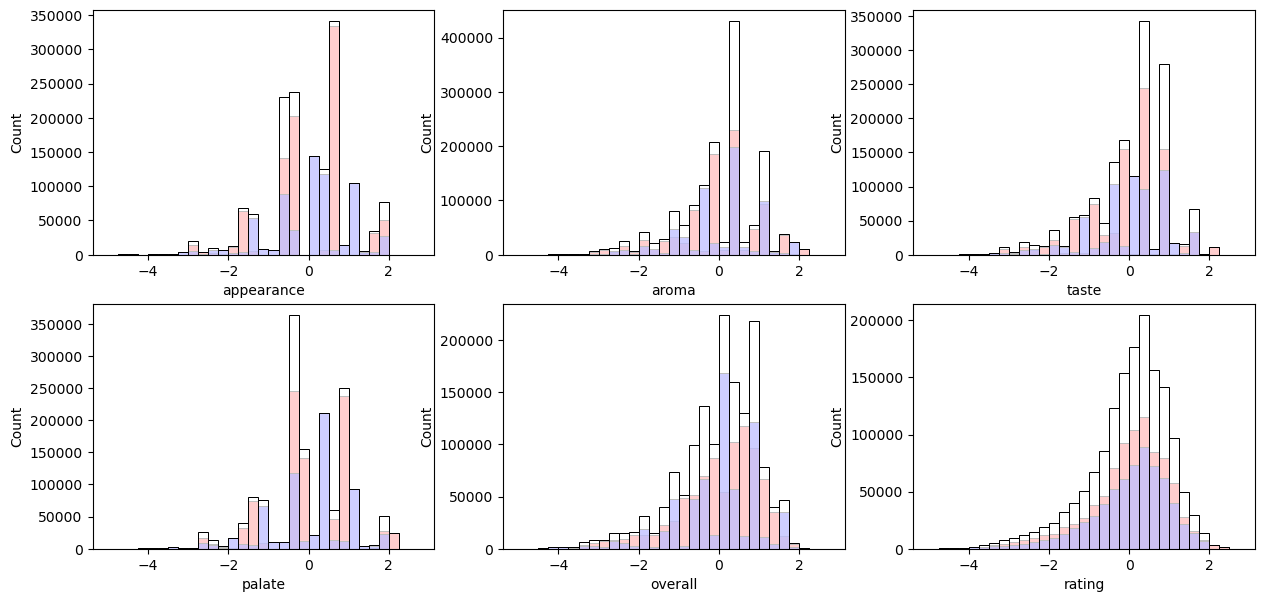

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
sns.histplot(RB_US_norm['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='red')
sns.histplot(BA_US_norm['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='blue')
sns.histplot(df_ratings['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='white')
sns.histplot(RB_US_norm['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='red')
sns.histplot(BA_US_norm['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='blue')
sns.histplot(df_ratings['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='white')
sns.histplot(RB_US_norm['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='red')
sns.histplot(BA_US_norm['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='blue')
sns.histplot(df_ratings['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='white')
sns.histplot(RB_US_norm['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='red')
sns.histplot(BA_US_norm['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='blue')
sns.histplot(df_ratings['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='white')
sns.histplot(RB_US_norm['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='red')
sns.histplot(BA_US_norm['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='blue')
sns.histplot(df_ratings['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='white')
sns.histplot(RB_US_norm['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='red')
sns.histplot(BA_US_norm['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='blue')
sns.histplot(df_ratings['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='white')
plt.show()

# Analysis

## Quick statistics from the data

### Number of reviews per state
blip-blap-bloop

### Number of reviews per beer
bli-blap-bloop

### Number of reviews per brewery
blip-blop-bloop

## 2 - Digging deeper, fine-tuning our analysis
### 2.1 - PCA on the rating aspects

First we load the necessary dataframes for the analysis. We use the `RB_US` and `BA_US` dataframes that we created in the preprocessing part. We will merge them into one dataframe `data_4_PCA` that we will use for the PCA analysis. We also scale the dataframe to have a mean of 0 and a standard deviation of 1 which is necessary for the PCA analysis.

In [118]:
features = ['appearance','aroma','taste','palate']
target = 'overall'

In [129]:
data_4_PCA = df_ratings
features_PCA = data_4_PCA[features]
target_PCA = data_4_PCA[target]

We then start our PCA analysis.

In [40]:
pca = PCA(n_components=2)
pca.fit(features_PCA)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.73276579, 0.12129502])

The first component explains 73.2 % of the variance and the second 12.1 % of the variance. 

In [128]:
scores = pca.transform(features_PCA)
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2'])
print(scores_df)
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)
df_loadings.abs()

              PC1       PC2
0        3.493510 -0.182266
1        1.082807 -0.430493
2        1.361585 -0.278288
3        1.622807 -0.162092
4        2.171104  0.500372
...           ...       ...
1522492  1.683228 -1.283530
1522493 -0.347992 -0.015796
1522494  3.577703  0.570320
1522495  1.336223  0.935942
1522496  6.012310  0.826056

[1522497 rows x 2 columns]


,PC1,PC2
appearance,0.461536,0.861190
aroma,0.507929,0.346644
taste,0.527008,0.367619
palate,0.501254,0.055185


As we can see for the first component, which explains 73.2 % of the variance, the most important feature is taste. 

### 2.2 - Multiple regression analysis on the rating aspects

To perform the multiple regression analysis, we will use the scikit-learn library. We will use the data we prepared in 2.1 : `features_PCA` and `target_PCA`. We use a the LinearRegression model from scikit-learn to fit the model on the data.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(features_PCA, target_PCA, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

We also also want to determine the coefficient of determination $R^2$ of the prediction which will tell us if our model is good or not. 

In [121]:
r2 = regressor.score(X_test, y_test)
print(f"Coefficient of determination: {r2:.2f}")

Coefficient of determination: 0.75


We can see that the coefficient of determination is 0.75 which is a good value. The data was centered in 2.1 and LinearRegression automatically adds an intercept. Thus the coefficient of determination R^2 is the centered R^2.

In [122]:
weights = regressor.coef_
print(weights)

[0.04819957 0.14019966 0.58786571 0.17108195]


Finally as expected we see that the most important feature is taste. The next most important features are palate and aroma, it seems palate is a bit more important than aroma.

### Correlation between the rating aspects

We will explore the correlation between the rating aspects by simply plotting a heatmap of the correlation matrix.


In [126]:
multi_reg_df = pd.concat([pd.DataFrame(features_PCA), pd.DataFrame(target_PCA)], axis=1)
multi_reg_df.columns = [features + ['overall']]

In [127]:
# Create a correlation matrix 
corr_metrics = multi_reg_df.corr()
corr_metrics.style.background_gradient(cmap='Blues')

,"('appearance',)","('aroma',)","('taste',)","('palate',)","('overall',)"
appearance,1.000000,0.574883,0.575271,0.590686,0.567657
aroma,0.574883,1.000000,0.768254,0.619722,0.725403
taste,0.575271,0.768254,1.000000,0.722105,0.846563
palate,0.590686,0.619722,0.722105,1.000000,0.710442
overall,0.567657,0.725403,0.846563,0.710442,1.000000


### Let's dig deeper 

We take a look at 2 beers with low and high scores for taste. We will look at the distribution of the scores for the different features for these two beers.

#### Mild taste beers

We choose two known beer types for their mild taste : American Adjunct Lager (Budweiser) and Pale Lager. 

In [194]:
AALager = df_ratings[features + [target]][df_ratings['style'] =='American Adjunct Lager']
AALager_mean = AALager[features + [target]].mean().to_frame()
AALager_mean.columns = ['mean']
print(AALager_mean)

corr_metrics = AALager.corr()
corr_metrics.style.background_gradient(cmap='Blues')

                mean
appearance -1.655133
aroma      -1.762767
taste      -1.492675
palate     -1.443979
overall    -1.203801


,appearance,aroma,taste,palate,overall
appearance,1.000000,0.606098,0.552732,0.567048,0.484039
aroma,0.606098,1.000000,0.720952,0.642395,0.621099
taste,0.552732,0.720952,1.000000,0.741753,0.786518
palate,0.567048,0.642395,0.741753,1.000000,0.686194
overall,0.484039,0.621099,0.786518,0.686194,1.000000


In [195]:
Pale_lager = df_ratings[features + [target]][df_ratings['style'] =='Pale Lager']
Pale_lager_mean = Pale_lager[features + [target]].mean().to_frame()
Pale_lager_mean.columns = ['mean']
print(Pale_lager_mean)

corr_metrics = Pale_lager.corr()
corr_metrics.style.background_gradient(cmap='Blues')

                mean
appearance -1.203661
aroma      -1.525418
taste      -1.413151
palate     -1.114865
overall    -1.493772


,appearance,aroma,taste,palate,overall
appearance,1.000000,0.584957,0.591192,0.612008,0.582359
aroma,0.584957,1.000000,0.790397,0.629869,0.752618
taste,0.591192,0.790397,1.000000,0.701407,0.850653
palate,0.612008,0.629869,0.701407,1.000000,0.684951
overall,0.582359,0.752618,0.850653,0.684951,1.000000


#### Strong taste beers

We choose two known beer types for their strong taste : IPA and Stout.

In [196]:
ipa = df_ratings[features + [target]][df_ratings['style'] =='India Pale Ale (IPA)']
ipa_mean = ipa[features + [target]].mean().to_frame()
ipa_mean.columns = ['mean']
print(ipa_mean)

corr_metrics = ipa.corr()
corr_metrics.style.background_gradient(cmap='Blues')

                mean
appearance  0.138157
aroma       0.310792
taste       0.261404
palate      0.190069
overall     0.288252


,appearance,aroma,taste,palate,overall
appearance,1.000000,0.310514,0.330532,0.426723,0.323251
aroma,0.310514,1.000000,0.638385,0.389967,0.600414
taste,0.330532,0.638385,1.000000,0.545122,0.761574
palate,0.426723,0.389967,0.545122,1.000000,0.529104
overall,0.323251,0.600414,0.761574,0.529104,1.000000


In [198]:
stout = df_ratings[features + [target]][df_ratings['style'] == 'Stout'] 
stout[features + [target]].mean().to_frame()

stout = df_ratings[features + [target]][df_ratings['style'] =='Stout']
stout_mean = stout[features + [target]].mean().to_frame()
stout_mean.columns = ['mean']
print(stout_mean)

corr_metrics = stout.corr()
corr_metrics.style.background_gradient(cmap='Blues')

                mean
appearance  0.539280
aroma       0.419297
taste       0.382295
palate      0.296053
overall     0.404042


,appearance,aroma,taste,palate,overall
appearance,1.000000,0.311131,0.355730,0.421298,0.360406
aroma,0.311131,1.000000,0.610456,0.386428,0.585246
taste,0.355730,0.610456,1.000000,0.562320,0.777420
palate,0.421298,0.386428,0.562320,1.000000,0.560987
overall,0.360406,0.585246,0.777420,0.560987,1.000000


In [247]:
beerstyle_taste = df_ratings[df_ratings['style'].isin(['India Pale Ale (IPA)', 'Stout', 'Pale Lager', 'American Adjunct Lager'])].groupby(['style', 'US_Code_User']).size().reset_index(name='count_users')
beerstyle_taste.index = beerstyle_taste['US_Code_User']
beerstyle_taste = beerstyle_taste.pivot(columns='style', values='count_users')
beerstyle_taste['total'] = beerstyle_taste.sum(axis=1)
beerstyle_taste.reset_index(inplace=True)
fig = px.choropleth(beerstyle_taste, 
                    locations='US_Code_User',  
                    locationmode='USA-states',  
                    scope="usa", 
                    color='total',
                    hover_data=['India Pale Ale (IPA)', 'Stout', 'Pale Lager', 'American Adjunct Lager'],
                    )
fig.update_layout(title_text='RateBeer - Number of users per country') 
fig.show()

In [245]:
beerstyle_taste

style,US_Code_User,American Adjunct Lager,India Pale Ale (IPA),Pale Lager,Stout,total
0,AK,39,147,212,66,464
1,AL,72,528,904,161,1665
2,AR,44,88,278,52,462
3,AZ,178,1238,1582,401,3399
4,CA,1122,6094,7514,1800,16530
5,CO,330,1816,2075,573,4794
6,CT,223,641,713,171,1748
7,DE,20,316,310,80,726
8,FL,553,2542,4441,870,8406
9,GA,339,1649,2132,475,4595


In [272]:
fig = px.choropleth(
    beerstyle_taste,
    locationmode='USA-states',  
    scope="usa",
    locations="US_Code_User", 
    color="total", 
)

# Add a dropdown menu
updatemenus = list([
    dict(
        buttons=list([
            dict(
                label="Total",
                args=[{"color": "total"}, {"title": "total"}],
                method="update",
            ),
            dict(
                label="American Adjunct Lager",
                args=[{"color": "American Adjunct Lager"}, {"title": "American Adjunct Lager"}],
                method="update",
            ),
            dict(
                label="Pale Lager",
                args=[{"color": "Pale Lager"}, {"title": "Pale Lager"}],
                method="update",
            ),
            dict(
                label="India Pale Ale (IPA)",
                args=[{"color": "India Pale Ale (IPA)"}, {"title": "India Pale Ale (IPA)"}],
                method="update",
            ),
            dict(
                label="Stout",
                args=[{"color": "Stout"}, {"title": "Stout"}],
                method="update",
            ),
        ]),
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = False,
        x = 0.1,
        xanchor = 'left',
        y = 1.1,
        yanchor = 'top' 
    ),
])

plt.show()


## Time series analysis

In [47]:
df_ratings_notnormalized = pd.concat([RB_US, BA_US], ignore_index=True)
#create dataframe with mean overall rating over time using a monthly frequency
df_ratings['date'] = pd.to_datetime(df_ratings_notnormalized['date'])
df_ratings = df_ratings.set_index('date')
df_ratings = df_ratings.resample('M').mean()
df_ratings = df_ratings.reset_index()
df_ratings = df_ratings.dropna()

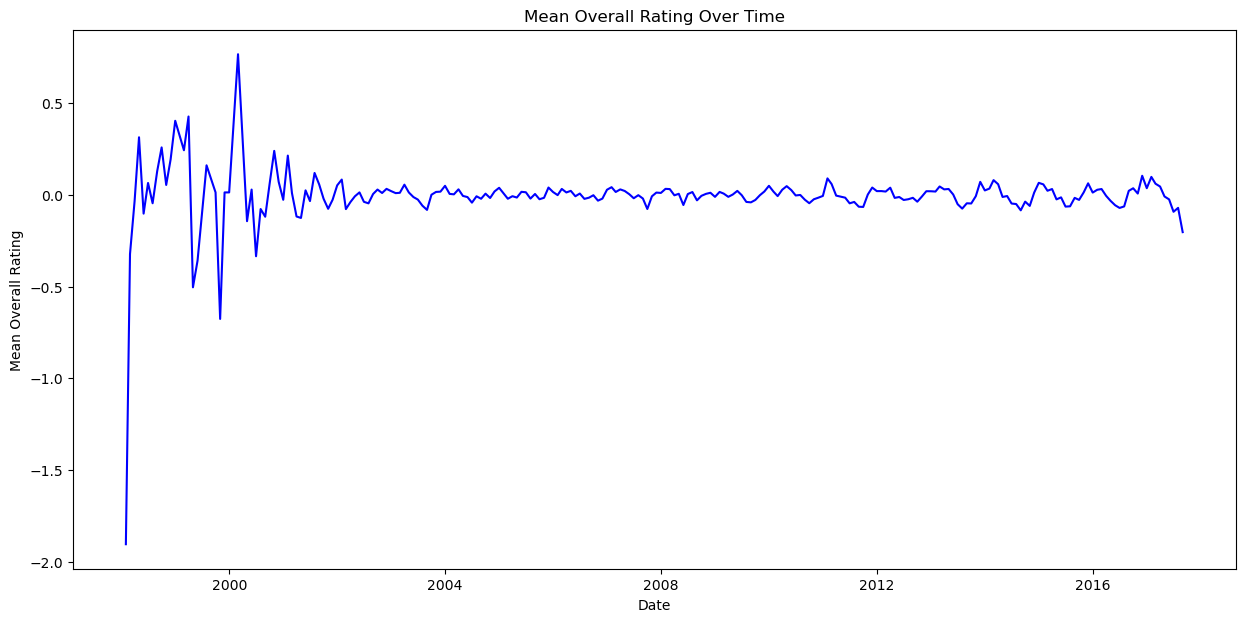

In [48]:
#plot the mean overall rating over time
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_ratings['date'], df_ratings['overall'], color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Overall Rating')
ax.set_title('Mean Overall Rating Over Time')
plt.show()

In [49]:
#open csv file called 'results_by_state_V2.csv' and read it into a dataframe
df_state = pd.read_csv('results_by_state_V2.csv')


In [50]:
df_state

,Republican,Republican%,Democratic,Democratic%,Total,State,year
0,941173.0,56.48%,692611.0,41.57%,1666272.0,AL,2000
1,167398.0,58.62%,79004.0,27.67%,285560.0,AK,2000
2,781652.0,51.02%,685341.0,44.73%,1532016.0,AZ,2000
3,472940.0,51.31%,422768.0,45.86%,921781.0,AR,2000
4,4567429.0,41.65%,5861203.0,53.45%,10965856.0,CA,2000
...,...,...,...,...,...,...,...
255,1221747.0,36.83%,1742718.0,52.54%,3317019.0,WA,2016
256,489371.0,68.50%,188794.0,26.43%,714423.0,WV,2016
257,1405284.0,47.22%,1382536.0,46.45%,2976150.0,WI,2016
258,174419.0,68.17%,55973.0,21.88%,255849.0,WY,2016


In [51]:
WV_evolution= df_state[df_state['State'] == 'WV']

In [55]:
df_ratings_notnormalized

,US_Code_User,location_user,US_Code_Beer,beers_location,beer_name,beer_id,brewery_name,brewery_id,style,abv,...,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,year
0,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,Jeppe,9058.0,-1.559341,-2.235325,-1.333284,-1.840803,-2.340502,-2.245245,Foamy though disappearing white head on a piss...,2004
1,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,tangentrider,54911.0,-0.484984,-2.377618,0.907404,-0.201415,-0.867184,-0.927946,Pale beer with a one inch disappearing head. ...,2008
2,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,posikyle,52600.0,-0.484984,-2.377618,-0.269863,0.389338,-0.296299,-0.669736,"Typical pale lager, but one of the best out th...",2008
3,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,Rictus,43333.0,-0.459524,-1.195765,-1.416326,-0.177260,-0.283165,-0.641413,The aroma is alittle too light for my taste. U...,2007
4,AL,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.0,...,JonnyC22,42655.0,-1.631093,-1.770414,-0.242687,-0.754075,-0.824391,-1.139337,Bottle (6âer) bought at halftime of Fla. St....,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522492,WY,United States,NaN,United States,Shiner Hefeweizen,1552.0,Spoetzl Brewery / Shiner,143.0,Hefeweizen,5.4,...,Bitterbill,bitterbill.708,0.207195,-1.118293,-0.431926,-1.886762,-1.991098,-1.705623,"This one pours a hazy, almost cloudy straw gol...",2009
1522493,WY,United States,NaN,Bangladesh,Dark O' The Moon,39497.0,Elysian Brewing Company,700.0,Pumpkin Ale,6.5,...,Bitterbill,bitterbill.708,0.080718,-0.094244,0.556130,0.151505,0.548954,0.222611,On draught at the Keg &amp; Cork. Pours a hazy...,2016
1522494,WY,United States,NaN,Laos,Taj Mahal Premium Lager,2970.0,United Breweries - UB Group,91.0,American Adjunct Lager,4.5,...,Bitterbill,bitterbill.708,-2.280039,-1.847700,-1.202883,-1.867017,-1.243819,-1.956139,"$3.95 for the 650ml bottle, batch 1277, mfd 09...",2010
1522495,WY,United States,NaN,Venezuela,Michelob Light,1253.0,Anheuser-Busch,29.0,Light Lager,4.3,...,Bitterbill,bitterbill.708,-1.464135,-1.118293,-0.431926,0.235378,-0.542276,-0.457071,It pours a yellow gold with a small head of fo...,2009


In [52]:
WV_evolution

,Republican,Republican%,Democratic,Democratic%,Total,State,year
48,336475.0,51.92%,295497.0,45.59%,648124.0,WV,2000
100,423778.0,56.06%,326541.0,43.20%,755887.0,WV,2004
152,397466.0,55.71%,303857.0,42.59%,713451.0,WV,2008
204,417655.0,62.3%,238269.0,35.5%,670438.0,WV,2012
256,489371.0,68.50%,188794.0,26.43%,714423.0,WV,2016


In [57]:
WV_reviews = df_ratings_notnormalized[df_ratings_notnormalized['US_Code_User'] == 'WV']

In [58]:
WV_reviews

,US_Code_User,location_user,US_Code_Beer,beers_location,beer_name,beer_id,brewery_name,brewery_id,style,abv,...,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,year
837731,WV,United States,AL,United States,Tiger Beer,3126.0,Singapore Brewery (Asia Pacific Breweries-Hein...,547.0,Pale Lager,5.00,...,weihenweizen,98012.0,-0.549227,-0.159341,-1.537460,-1.433244,-0.890370,-0.996769,Refrigerated beer poured into a shaker. Pours...,2011
837732,WV,United States,AK,United States,Ramstein Blonde,3399.0,High Point Brewing Company,588.0,German Hefeweizen,5.50,...,weihenweizen,98012.0,0.498348,0.358889,-0.491670,0.304280,0.238636,0.257313,Refrigerated 12 oz. brown bottle best by June ...,2017
837733,WV,United States,AZ,United States,Maisels Weisse Kristall,6089.0,Brauerei Gebr. Maisel Bayreuth,778.0,German Kristallweizen,5.10,...,weihenweizen,98012.0,-1.727446,-0.732006,-1.523319,-0.246794,-0.562168,-0.841377,Refrigerated 0.5 L brown bottle poured into a ...,2014
837734,WV,United States,AZ,United States,Malheur 12,11337.0,Brouwerij Malheur (formerly De Landtsheer),900.0,Belgian Strong Ale,12.00,...,mnoud,148550.0,-0.569205,1.017058,-0.372970,1.510664,0.825915,0.838858,12oz bottle in pint glass. Pours an opaque br...,2012
837735,WV,United States,AZ,United States,Scotch Silly,2425.0,Brasserie de Silly,419.0,Scotch Ale,8.00,...,weihenweizen,98012.0,-0.615189,-0.203285,-1.587897,0.334892,-0.042460,-0.243696,Refrigerated 75 cl brown bottle poured into a ...,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506775,WV,United States,NaN,Kenya,Wildflower Witbier,23392.0,Natty Greene's Pub & Brewing Co.,9792.0,Witbier,4.50,...,Treyliff,treyliff.490010,-0.755832,-0.150917,-1.372789,-0.981793,-1.031138,-0.876467,"No freshness date, poured into a pint. Bottle ...",2014
1506776,WV,United States,NaN,Bangladesh,Dark O' The Moon,39497.0,Elysian Brewing Company,700.0,Pumpkin Ale,6.50,...,Treyliff,treyliff.490010,0.014726,-0.160465,-0.588236,0.104255,-0.244882,-0.108679,22oz bottle poured into a snifterA- pours a je...,2015
1506777,WV,United States,NaN,Venezuela,Michelob Light,1253.0,Anheuser-Busch,29.0,Light Lager,4.30,...,WVbeergeek,wvbeergeek.775,-1.455699,-1.115786,-2.720457,-2.567068,-1.953802,-2.372775,Appears a pale fizzy yellow lager with decent ...,2010
1506778,WV,United States,NaN,Cayman Islands,Aspen Edge,16049.0,Coors Brewing Company,306.0,Light Lager,4.13,...,WVbeergeek,wvbeergeek.775,-3.619504,-3.028665,-3.844527,-3.675146,-3.156021,-3.844910,Appearance: Pale golden short lived white head...,2004


In [74]:
# plot number of reviews over time 
number_of_reviews_WV = WV_reviews.groupby('year').count()
number_of_reviews_WV 

,US_Code_User,location_user,US_Code_Beer,beers_location,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
year,,,,,,,,,,,,,,,,,,,,
2001,16,16,3,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2002,138,138,60,138,138,138,138,138,138,134,138,138,138,138,138,138,138,138,138,138
2003,383,383,184,383,383,383,383,383,383,367,383,383,383,383,383,383,383,383,383,383
2004,203,203,88,203,203,203,203,203,203,197,203,203,203,203,203,203,203,203,203,203
2005,75,75,37,75,75,75,75,75,75,73,75,75,75,75,75,75,75,75,75,75
2006,398,398,199,398,398,398,398,398,398,386,398,398,398,398,398,398,398,398,398,398
2007,412,412,205,412,412,412,412,412,412,401,412,412,412,412,412,412,412,412,412,412
2008,513,513,235,513,513,513,513,513,513,498,513,513,513,513,513,513,513,513,513,513
2009,457,457,193,457,457,457,457,457,457,455,457,457,457,457,457,457,457,457,457,457
